<a href="https://colab.research.google.com/github/SCS-hanyang/DM_hanyang/blob/main/DM_%EC%88%98%EC%97%85%EC%9E%90%EB%A3%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ema-pytorch

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Module, ModuleList
from torch.utils.data import  DataLoader
from torch.optim import Adam
from torch.amp import autocast

import torchvision
from torchvision import transforms as T, utils

from tqdm.auto import tqdm

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange

from functools import partial

import math

from ema_pytorch import EMA

from accelerate import Accelerator
from pathlib import Path
from multiprocessing import cpu_count

import matplotlib.pyplot as plt

## Helper function

In [ ]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def identity(t, *args, **kwargs):
    return t

def cycle(dl):
    while True:
        for data in dl:
            yield data

def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

def cast_tuple(t, length = 1):
    if isinstance(t, tuple):
        return t
    return ((t,) * length)

def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_to_zero_to_one(t):
    return (t + 1) * 0.5

def divisible_by(numer, denom):
    return (numer % denom) == 0

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

def view_image(imgs):
    num_images = imgs.shape[0]

    num_rows = 4
    num_cols = 4

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))

    for i in range(num_images):
        img = imgs[i].cpu().detach().squeeze().numpy()
        row = i // num_cols
        col = i % num_cols

        if num_rows == 1 and num_cols == 1:
            ax = axes
        elif num_rows == 1 or num_cols == 1:
            ax = axes[max(row, col)]
        else:
            ax = axes[row, col]

        ax.imshow(img, cmap='gray')
        ax.set_title(f'Image {i+1}')
        ax.axis('off')

    plt.tight_layout()

    plt.show()

def view_process(imgs):
    sample_indices = list(range(0, 1000 + 1, 50))

    num_samples_to_plot = len(sample_indices)

    num_cols = 5
    num_rows = (num_samples_to_plot + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2.5, num_rows * 2.5))
    axes = axes.flatten()
    imgs = imgs.squeeze(0)

    for i, data_idx in enumerate(sample_indices):

        ax = axes[i]

        if isinstance(imgs, torch.Tensor):

            img = imgs[data_idx].cpu().detach().squeeze().numpy()
        elif isinstance(imgs, np.ndarray):
            img = imgs[data_idx].squeeze()


        ax.imshow(img, cmap='gray')
        ax.set_title(f"t_step : {data_idx + 1}")
        ax.axis('off')

    for j in range(num_samples_to_plot, num_rows * num_cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

## schedule

In [ ]:
def beta_schedule(timesteps):

    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype = torch.float64)

alpha cumprod schedule : $\bar{\alpha}_t = \prod_{s=1}^{t} (1 - \beta_s)$

In [ ]:
def alpha_cumprod_schedule(betas):

    alphas = 1. - betas
    alpha_cumprod = torch.cumprod(alphas, dim=0)

    return alpha_cumprod


In [ ]:
def alphas_cumprod_prev(alphas_cumprod):

    return F.pad(alphas_cumprod[:-1], (1, 0), value = 1.)

def sqrt_alphas_cumprod(alphas_cumprod):

    return torch.sqrt(alphas_cumprod)

def sqrt_one_minus_alphas_cumprod(alphas_cumprod):

    return torch.sqrt(1. - alphas_cumprod)

def sqrt_recip_alphas(betas):

    alphas = 1. - betas
    return torch.sqrt(1. / alphas)

def sqrt_recip_one_minus_alphas_cumprod(alphas_cumprod):

    return torch.sqrt(1. / (1 - alphas_cumprod))

def posterior_variance(betas, alphas_cumprods_prev, alphas_cumprod):

    return betas * (1. - alphas_cumprods_prev) / (1. - alphas_cumprod)


## forward process

$q(\mathbf{x}_{1:T} \mid \mathbf{x}_0) = \prod_{t=1}^{T} q(\mathbf{x}_t \mid \mathbf{x}_{t-1})$

q_sample : $q(\mathbf{x}_t \mid \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t}\mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})$

In [ ]:
def q_sample(x_start, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, noise = None):
    noise = default(noise, lambda: torch.randn_like(x_start))

    sqrt_alpha_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alpha_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    x_t = sqrt_alpha_cumprod_t * x_start + sqrt_one_minus_alpha_cumprod_t * noise

    return x_t


## reverse process

p sample : $p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1}; \mu_\theta(\mathbf{x}_t, t), \Sigma_\theta(\mathbf{x}_t, t))$

model_mean $$\frac{1}{\sqrt{\alpha_t}}\left(\mathbf{x}_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}}\boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t)\right)$$

posterior_variance
$$\tilde{\beta}_t := \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t}\beta_t$$

In [ ]:
def p_sample(
    x,
    t,
    pretrained_model,
    betas,
    sqrt_recip_alphas,
    sqrt_recip_one_minus_alphas_cumprod,
    posterior_variance,
    ):

    noise = torch.randn_like(x_t)

    sqrt_recip_alpha_t = extract(sqrt_recip_alphas, t, x.shape)
    beta_t = extract(betas, t, x.shape)
    sqrt_recip_one_minus_alpha_cumprod_t = extract(sqrt_recip_one_minus_alphas_cumprod, t, x.shape)

    predicted_noise_epsilon = pretrained_model(x, t)

    model_mean = sqrt_recip_alpha_t * (x_t - beta_t * sqrt_recip_one_minus_alpha_cumprod_t * predicted_noise_epsilon)

    posterior_variance_t = extract(posterior_variance, t, x.shape)

    x_t = model_mean + posterior_variance_t * noise

    return x_t

In [ ]:
def p_sample_loop(self, shape, return_all_timesteps = True):
    batch, device = shape[0], self.device

    img = torch.randn(shape, device = device)
    imgs = [img]

    x_start = None

    for t in tqdm(reversed(range(0, self.num_timesteps)), desc = 'sampling loop time step', total = self.num_timesteps):
        img = self.p_sample(img, t)
        imgs.append(img)

    ret = img if not return_all_timesteps else torch.stack(imgs, dim = 1)

    ret = self.unnormalize(ret)
    return ret


loss $$\mathbb{E}_{\mathbf{x}_0, \boldsymbol{\epsilon}}\left[\|\boldsymbol{\epsilon} - \boldsymbol{\epsilon}_\theta(\sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon}, t)\|^2\right]$$

In [ ]:
def p_losses(x_start, t, noise = None):
        b, c, h, w = x_start.shape

        noise = default(noise, lambda: torch.randn_like(x_start))

        x = q_sample(x_start = x_start, t = t, noise = noise)

        model_out = model(x, t)
        loss = F.mse_loss(model_out, noise, reduction = 'none')
        loss = reduce(loss, 'b ... -> b', 'mean')

        return loss.mean()

## UNet

In [ ]:
def Upsample(dim, dim_out = None):
    return nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'nearest'),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding = 1)
    )

def Downsample(dim, dim_out = None):
    return nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1 = 2, p2 = 2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1)
    )

class RMSNorm(Module):
    def __init__(self, dim):
        super().__init__()
        self.scale = dim ** 0.5
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        return F.normalize(x, dim = 1) * self.g * self.scale

In [ ]:
class Block(Module):
    def __init__(self, dim, dim_out, dropout = 0.):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = RMSNorm(dim_out)
        self.act = nn.SiLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return self.dropout(x)

In [ ]:
class ResnetBlock(Module):
    def __init__(self, dim, dim_out, *, time_emb_dim = None, dropout = 0.):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, dim_out * 2)
        ) if exists(time_emb_dim) else None

        self.block1 = Block(dim, dim_out, dropout = dropout)
        self.block2 = Block(dim_out, dim_out)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb = None):

        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            scale_shift = time_emb.chunk(2, dim = 1)

        h = self.block1(x, scale_shift = scale_shift)

        #h = self.block2(h)

        return h + self.res_conv(x)

In [ ]:
class AttentionBlock(Module):
    def __init__(
        self,
        dim,
        heads = 4,
        dim_head = 32,
        num_mem_kv = 4
    ):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads

        self.norm = RMSNorm(dim)

        self.mem_kv = nn.Parameter(torch.randn(2, heads, dim_head, num_mem_kv))
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)

        self.to_out = nn.Sequential(
            nn.Conv2d(hidden_dim, dim, 1),
            RMSNorm(dim)
        )


    def forward(self, x):
        b, c, h, w = x.shape

        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        mk, mv = map(lambda t: repeat(t, 'h c n -> b h c n', b = b), self.mem_kv)
        k, v = map(partial(torch.cat, dim = -1), ((mk, k), (mv, v)))

        q = q.softmax(dim = -2)
        k = k.softmax(dim = -1)

        q = q * self.scale

        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b (h c) x y', h = self.heads, x = h, y = w)
        return self.to_out(out)


In [ ]:
class SinusoidalPosEmb(Module):
    def __init__(self, dim, theta = 10000):
        super().__init__()
        self.dim = dim
        self.theta = theta

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(self.theta) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

UNet Architecture

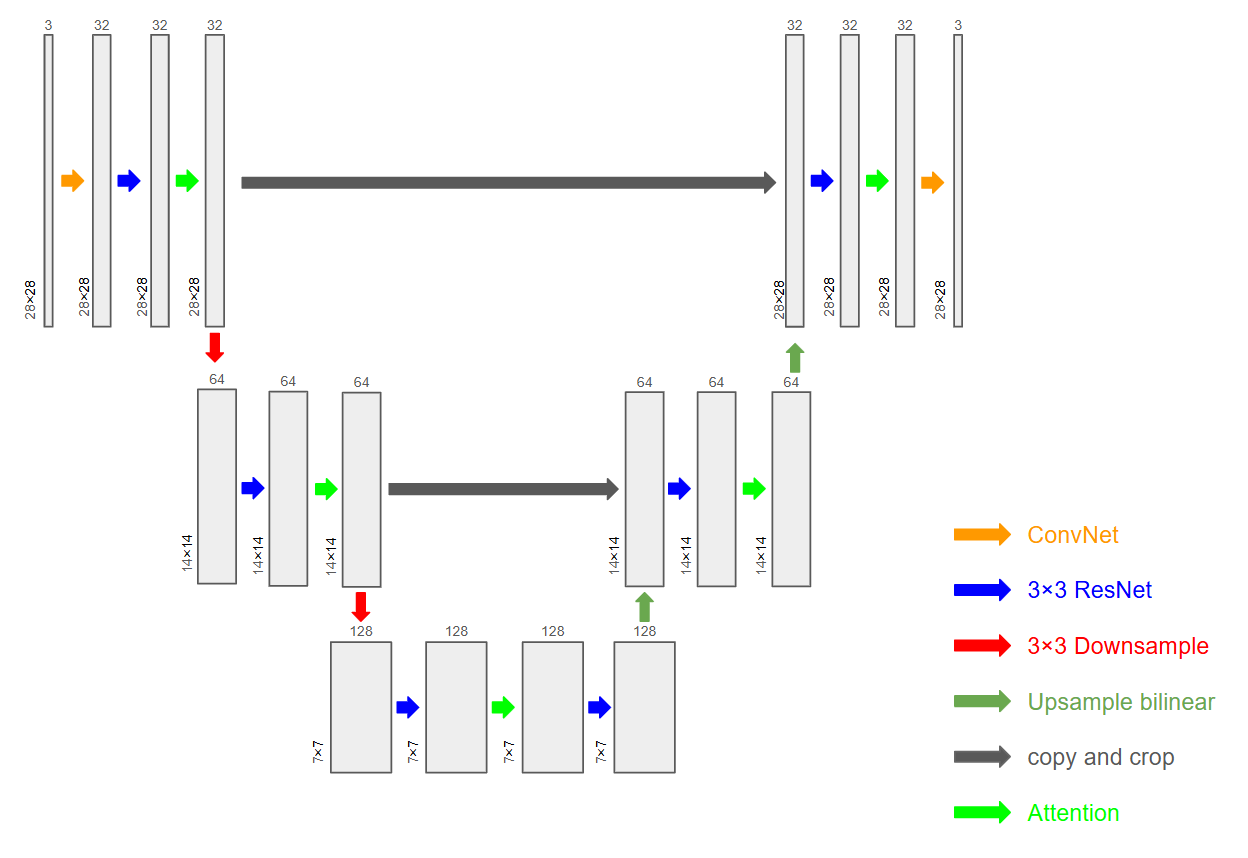

In [ ]:
class Unet(Module):
    def __init__(
        self,
        dim,
        dim_mults = (1, 2, 4),
        channels = 1,
        sinusoidal_pos_emb_theta = 10000,
        dropout = 0.,
        attn_dim_head = 32,
        attn_heads = 4,
    ):
        super().__init__()

        self.channels = channels

        init_dim = dim
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding = 3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        # time embeddings

        time_dim = dim * 4

        sinu_pos_emb = SinusoidalPosEmb(dim, theta = sinusoidal_pos_emb_theta)

        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        # attention

        num_stages = len(dim_mults)
        attn_heads = cast_tuple(attn_heads, num_stages)
        attn_dim_head = cast_tuple(attn_dim_head, num_stages)

        resnet_block = partial(ResnetBlock, time_emb_dim = time_dim, dropout = dropout)

        # layers

        self.downs = ModuleList([])
        self.ups = ModuleList([])
        num_resolutions = len(in_out)

        for ind, ((dim_in, dim_out), layer_attn_heads, layer_attn_dim_head) in enumerate(zip(in_out, attn_heads, attn_dim_head)):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(ModuleList([
                resnet_block(dim_in, dim_in),
                resnet_block(dim_in, dim_in),
                AttentionBlock(dim_in, dim_head = layer_attn_dim_head, heads = layer_attn_heads) if ind == 1 else nn.Identity(),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding = 1)
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = resnet_block(mid_dim, mid_dim)
        self.mid_attn = AttentionBlock(mid_dim, heads = attn_heads[-1], dim_head = attn_dim_head[-1])
        self.mid_block2 = resnet_block(mid_dim, mid_dim)

        for ind, ((dim_in, dim_out), layer_attn_heads, layer_attn_dim_head) in enumerate(zip(*map(reversed, (in_out, attn_heads, attn_dim_head)))):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(ModuleList([
                resnet_block(dim_out + dim_in, dim_out),
                resnet_block(dim_out + dim_in, dim_out),
                AttentionBlock(dim_out, dim_head = layer_attn_dim_head, heads = layer_attn_heads) if ind == 1 else nn.Identity(),
                Upsample(dim_out, dim_in) if not is_last else  nn.Conv2d(dim_out, dim_in, 3, padding = 1)
            ]))

        #if ind == 1 else nn.Identity(),
        self.out_dim = channels

        self.final_res_block = resnet_block(init_dim * 2, init_dim)
        self.final_conv = nn.Conv2d(init_dim, self.out_dim, 1)


    def forward(self, x, time, x_self_cond = None):

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            #x = block2(x, t)
            x = attn(x) + x
            #h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x) + x
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim = 1)
            x = block1(x, t)

            #x = torch.cat((x, h.pop()), dim = 1)
            #x = block2(x, t)
            x = attn(x) + x

            x = upsample(x)


        x = torch.cat((x, r), dim = 1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)

## Diffusion Model

In [ ]:
class Diffusion(Module):
    def __init__(
        self,
        model,
        *,
        image_size,
        timesteps = 1000,
        sampling_timesteps = 1000,
        auto_normalize = True,
    ):
        super().__init__()

        self.model = model
        device = next(model.parameters()).device

        self.channels = self.model.channels

        self.image_size = image_size

        betas = beta_schedule(timesteps)
        betas = betas.to(device)

        alphas = 1. - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value = 1.)

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)

        # sampling related parameters

        self.sampling_timesteps = default(sampling_timesteps, timesteps)

        register_buffer = lambda name, val: self.register_buffer(name, val.to(torch.float32))

        register_buffer('betas', betas)
        register_buffer('alphas_cumprod', alphas_cumprod)
        register_buffer('alphas_cumprod_prev', alphas_cumprod_prev)

        # calculations for diffusion q(x_t | x_{t-1}) and others

        register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1. - alphas_cumprod))
        register_buffer('sqrt_recip_alphas', torch.sqrt(1. / alphas))
        register_buffer('sqrt_recip_one_minus_alphas_cumprod', torch.sqrt(1. / (1 - alphas_cumprod)))

        posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

        register_buffer('posterior_variance', posterior_variance)

        self.normalize = normalize_to_neg_one_to_one if auto_normalize else identity
        self.unnormalize = unnormalize_to_zero_to_one if auto_normalize else identity

    @property
    def device(self):
        return self.betas.device

    def predict_start_from_noise(self, x_t, t, noise):
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def predict_noise_from_start(self, x_t, t, x0):
        return (
            (extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - x0) / \
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)
        )

    @torch.inference_mode()
    def p_sample(self, x, time):

        b, *_, device = *x.shape, self.device
        t = torch.full((b,), time, device = device, dtype = torch.long)

        noise = torch.randn_like(x) if time > 0 else 0

        sqrt_recip_alpha_t = extract(self.sqrt_recip_alphas, t, x.shape)
        beta_t = extract(self.betas, t, x.shape)
        sqrt_recip_one_minus_alpha_cumprod_t = extract(self.sqrt_recip_one_minus_alphas_cumprod, t, x.shape)

        predicted_noise_epsilon = self.model(x, t)

        model_mean = sqrt_recip_alpha_t * (x - beta_t * sqrt_recip_one_minus_alpha_cumprod_t * predicted_noise_epsilon)

        posterior_variance_t = extract(self.posterior_variance, t, x.shape)

        pred_img = model_mean + torch.sqrt(posterior_variance_t) * noise

        return pred_img


    @torch.inference_mode()
    def p_sample_loop(self, shape ,return_all_timesteps = False):
        batch, device = shape[0], self.device

        img = torch.randn(shape, device = device)
        imgs = [img]

        x_start = None

        for t in tqdm(reversed(range(0, self.num_timesteps)), desc = 'sampling loop time step', total = self.num_timesteps):
            img = self.p_sample(img, t)
            imgs.append(img)

        ret = img if not return_all_timesteps else torch.stack(imgs, dim = 1)

        ret = self.unnormalize(ret)
        return ret


    def sample(self, batch_size = 16 , return_all_timesteps = False):
        (h, w), channels = (self.image_size,self.image_size), self.channels
        sample_fn = self.p_sample_loop
        return sample_fn((batch_size, channels, h, w), return_all_timesteps = return_all_timesteps)

    @autocast('cuda', enabled = False)
    def q_sample(self, x_start, t, noise = None):
        noise = default(noise, lambda: torch.randn_like(x_start))

        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )

    def p_losses(self, x_start, t, noise = None):
        b, c, h, w = x_start.shape

        noise = default(noise, lambda: torch.randn_like(x_start))

        x = self.q_sample(x_start = x_start, t = t, noise = noise)

        model_out = self.model(x, t)
        loss = F.mse_loss(model_out, noise, reduction = 'none')
        loss = reduce(loss, 'b ... -> b', 'mean')

        #loss = loss * extract(self.loss_weight, t, loss.shape)
        return loss.mean()

    def forward(self, img, *args, **kwargs):
        b, c, h, w, device, img_size, = *img.shape, img.device, self.image_size
        t = torch.randint(0, self.num_timesteps, (b,), device=device).long()

        img = self.normalize(img)
        return self.p_losses(img, t, *args, **kwargs)

## Trainer


In [ ]:
class Trainer:
    def __init__(
        self,
        diffusion_model,
        *,
        train_batch_size = 16,
        gradient_accumulate_every = 1,
        train_lr = 1e-4,
        train_num_steps = 21000,
        ema_update_every = 10,
        ema_decay = 0.995,
        adam_betas = (0.9, 0.99),
        save_and_sample_every = 1000,
        num_samples = 25,
        results_folder = './results',
        amp = True,
        mixed_precision_type = 'fp16',
        split_batches = True,
        inception_block_idx = 2048,
        max_grad_norm = 1.,
        num_fid_samples = 50000,
        save_best_and_latest_only = False
    ):
        super().__init__()

        # accelerator

        self.accelerator = Accelerator(
            split_batches = split_batches,
            mixed_precision = mixed_precision_type if amp else 'no'
        )

        # model

        self.model = diffusion_model
        self.channels = diffusion_model.channels

        self.num_samples = num_samples
        self.save_and_sample_every = save_and_sample_every

        self.batch_size = train_batch_size
        self.gradient_accumulate_every = gradient_accumulate_every

        self.train_num_steps = train_num_steps
        self.image_size = diffusion_model.image_size

        self.max_grad_norm = max_grad_norm

        # dataset and dataloader

        transform = T.Compose([
            T.ToTensor(),
        ])

        self.ds = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)

        dl = DataLoader(self.ds, batch_size = train_batch_size, shuffle = True, pin_memory = True)

        dl = self.accelerator.prepare(dl)
        self.dl = cycle(dl)

        # optimizer

        self.opt = Adam(diffusion_model.parameters(), lr = train_lr, betas = adam_betas)

        # for logging results in a folder periodically

        if self.accelerator.is_main_process:
            self.ema = EMA(diffusion_model, beta = ema_decay, update_every = ema_update_every)
            self.ema.to(self.device)

        self.results_folder = Path(results_folder)
        self.results_folder.mkdir(exist_ok = True)

        # step counter state

        self.step = 0

        # prepare model, dataloader, optimizer with accelerator

        self.model, self.opt = self.accelerator.prepare(self.model, self.opt)

        self.save_best_and_latest_only = save_best_and_latest_only

    @property
    def device(self):
        return self.accelerator.device

    def save(self, milestone):
        if not self.accelerator.is_local_main_process:
            return

        data = {
            'step': self.step,
            'model': self.accelerator.get_state_dict(self.model),
            'opt': self.opt.state_dict(),
            'ema': self.ema.state_dict(),
            'scaler': self.accelerator.scaler.state_dict() if exists(self.accelerator.scaler) else None,
        }

        torch.save(data, str(self.results_folder / f'model-{milestone}.pt'))

    def load(self, milestone):
        accelerator = self.accelerator
        device = accelerator.device

        data = torch.load(str(self.results_folder / f'model-{milestone}.pt'), map_location=device, weights_only=True)

        model = self.accelerator.unwrap_model(self.model)
        model.load_state_dict(data['model'])

        self.step = data['step']
        self.opt.load_state_dict(data['opt'])
        if self.accelerator.is_main_process:
            self.ema.load_state_dict(data["ema"])

        if 'version' in data:
            print(f"loading from version {data['version']}")

        if exists(self.accelerator.scaler) and exists(data['scaler']):
            self.accelerator.scaler.load_state_dict(data['scaler'])

    def train(self):
        accelerator = self.accelerator
        device = accelerator.device

        with tqdm(initial = self.step, total = self.train_num_steps, disable = not accelerator.is_main_process) as pbar:

            while self.step < self.train_num_steps:
                self.model.train()

                total_loss = 0.

                for _ in range(self.gradient_accumulate_every):
                    imgs, _ = next(self.dl)
                    imgs = imgs.to(device)

                    with self.accelerator.autocast():
                        loss = self.model(imgs)
                        loss = loss / self.gradient_accumulate_every
                        total_loss += loss.item()

                    self.accelerator.backward(loss)

                pbar.set_description(f'loss: {total_loss:.4f}')

                accelerator.wait_for_everyone()
                accelerator.clip_grad_norm_(self.model.parameters(), self.max_grad_norm)

                self.opt.step()
                self.opt.zero_grad()

                accelerator.wait_for_everyone()

                self.step += 1
                if accelerator.is_main_process:
                    self.ema.update()

                    if self.step != 0 and divisible_by(self.step, self.save_and_sample_every):
                        self.ema.ema_model.eval()

                        with torch.inference_mode():
                            milestone = self.step // self.save_and_sample_every
                            batches = num_to_groups(self.num_samples, self.batch_size)
                            all_images_list = list(map(lambda n: self.ema.ema_model.sample(batch_size=n), batches))

                        all_images = torch.cat(all_images_list, dim = 0)

                        utils.save_image(all_images, str(self.results_folder / f'sample-{milestone}.png'), nrow = int(math.sqrt(self.num_samples)))

                        if self.save_best_and_latest_only:
                            self.save("latest")
                        else:
                            self.save(milestone)

                pbar.update(1)

        accelerator.print('training complete')

## Results

In [ ]:
unet = Unet(dim = 32)
model = Diffusion(model = unet, image_size=28)
trainer = Trainer(diffusion_model = model, train_batch_size=128, save_and_sample_every = 1000,)

trainer.train()

In [ ]:
unet = Unet(dim = 32)
model = Diffusion(model = unet, image_size=28)
trainer = Trainer(diffusion_model = model, train_batch_size=64, save_and_sample_every = 1000,)

for x in range(1,22,5):
    trainer.load(str(x))
    imgs = model.sample()
    view_image(imgs)


In [ ]:
process = model.sample(batch_size = 1, return_all_timesteps=True)
view_process(process)
